# Time series analysis of historical (1981-2021) weather data from Tokyo, Japan as well as time series forecasting of maximum and average temperatures using the xgboost module.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import statistics

from datetime import datetime
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (15,5)

In [2]:
df = pd.read_csv('tokyo_weather_cleaned.csv')
df.head()

,Date,Average pressure,Sea level pressure,Rainfall,Max rainfall (1 hour),Max rainfall (10 mins),Ave temp,Max temp,Min temp,Ave humidity,Min humidity,Ave wind speed,Hours of sunlight,Snowfall,Max snow cover,Gust x,Gust y,Max x,Max y
0,1981-01-01,1014.7,1019.2,0.0,0.0,0.0,5.0,8.9,1.3,51.0,31.0,2.5,8.7,0.0,0.0,6.744321,-2.793589,4.527010,-1.875149
1,1981-01-02,999.5,1003.8,2.0,2.0,1.0,4.6,7.5,1.9,81.0,42.0,2.6,3.5,0.0,0.0,-7.424621,-7.424621,-4.384062,-4.384062
2,1981-01-03,998.1,1002.5,0.0,0.0,0.0,5.1,9.0,2.2,40.0,19.0,4.8,8.9,0.0,0.0,-9.545942,-9.545942,-4.808326,-4.808326
3,1981-01-04,1004.8,1009.3,0.0,0.0,0.0,4.4,9.6,-0.6,47.0,32.0,3.8,8.6,0.0,0.0,15.613564,-6.467350,10.162675,-4.209518
4,1981-01-05,1006.5,1010.9,0.0,0.0,0.0,4.1,8.4,0.0,46.0,28.0,3.1,7.9,0.0,0.0,10.717003,-4.439128,6.929096,-2.870126


In [3]:
df = df[['Date','Ave temp','Max temp','Min temp']]
df

,Date,Ave temp,Max temp,Min temp
0,1981-01-01,5.0,8.9,1.3
1,1981-01-02,4.6,7.5,1.9
2,1981-01-03,5.1,9.0,2.2
3,1981-01-04,4.4,9.6,-0.6
4,1981-01-05,4.1,8.4,0.0
...,...,...,...,...
14875,2021-09-23,26.6,31.7,22.9
14876,2021-09-24,25.4,30.6,21.2
14877,2021-09-25,22.1,24.5,20.3
14878,2021-09-26,19.9,21.3,18.2


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
date_index = df['Date']
df.insert(loc=0, column='Date Index', value=date_index)
df = df.set_index('Date Index')
df

,Date,Ave temp,Max temp,Min temp
Date Index,,,,
1981-01-01,1981-01-01,5.0,8.9,1.3
1981-01-02,1981-01-02,4.6,7.5,1.9
1981-01-03,1981-01-03,5.1,9.0,2.2
1981-01-04,1981-01-04,4.4,9.6,-0.6
1981-01-05,1981-01-05,4.1,8.4,0.0
...,...,...,...,...
2021-09-23,2021-09-23,26.6,31.7,22.9
2021-09-24,2021-09-24,25.4,30.6,21.2
2021-09-25,2021-09-25,22.1,24.5,20.3


In [5]:
#create time series features
def create_features(df):
    df['Week'] = df.index.isocalendar().week
    df['Month'] =  df.index.month
    df['Quarter'] = df.index.quarter
    df['Year'] = df.index.year
    return df

In [6]:
df = create_features(df)
df

,Date,Ave temp,Max temp,Min temp,Week,Month,Quarter,Year
Date Index,,,,,,,,
1981-01-01,1981-01-01,5.0,8.9,1.3,1,1,1,1981
1981-01-02,1981-01-02,4.6,7.5,1.9,1,1,1,1981
1981-01-03,1981-01-03,5.1,9.0,2.2,1,1,1,1981
1981-01-04,1981-01-04,4.4,9.6,-0.6,1,1,1,1981
1981-01-05,1981-01-05,4.1,8.4,0.0,2,1,1,1981
...,...,...,...,...,...,...,...,...
2021-09-23,2021-09-23,26.6,31.7,22.9,38,9,3,2021
2021-09-24,2021-09-24,25.4,30.6,21.2,38,9,3,2021
2021-09-25,2021-09-25,22.1,24.5,20.3,38,9,3,2021


In [7]:
# daily temperature range
df['Temp variation'] = df.apply(lambda x: x['Max temp'] - x['Min temp'], axis=1)
df

,Date,Ave temp,Max temp,Min temp,Week,Month,Quarter,Year,Temp variation
Date Index,,,,,,,,,
1981-01-01,1981-01-01,5.0,8.9,1.3,1,1,1,1981,7.6
1981-01-02,1981-01-02,4.6,7.5,1.9,1,1,1,1981,5.6
1981-01-03,1981-01-03,5.1,9.0,2.2,1,1,1,1981,6.8
1981-01-04,1981-01-04,4.4,9.6,-0.6,1,1,1,1981,10.2
1981-01-05,1981-01-05,4.1,8.4,0.0,2,1,1,1981,8.4
...,...,...,...,...,...,...,...,...,...
2021-09-23,2021-09-23,26.6,31.7,22.9,38,9,3,2021,8.8
2021-09-24,2021-09-24,25.4,30.6,21.2,38,9,3,2021,9.4
2021-09-25,2021-09-25,22.1,24.5,20.3,38,9,3,2021,4.2


# Historical temperature analysis (1981-2021)

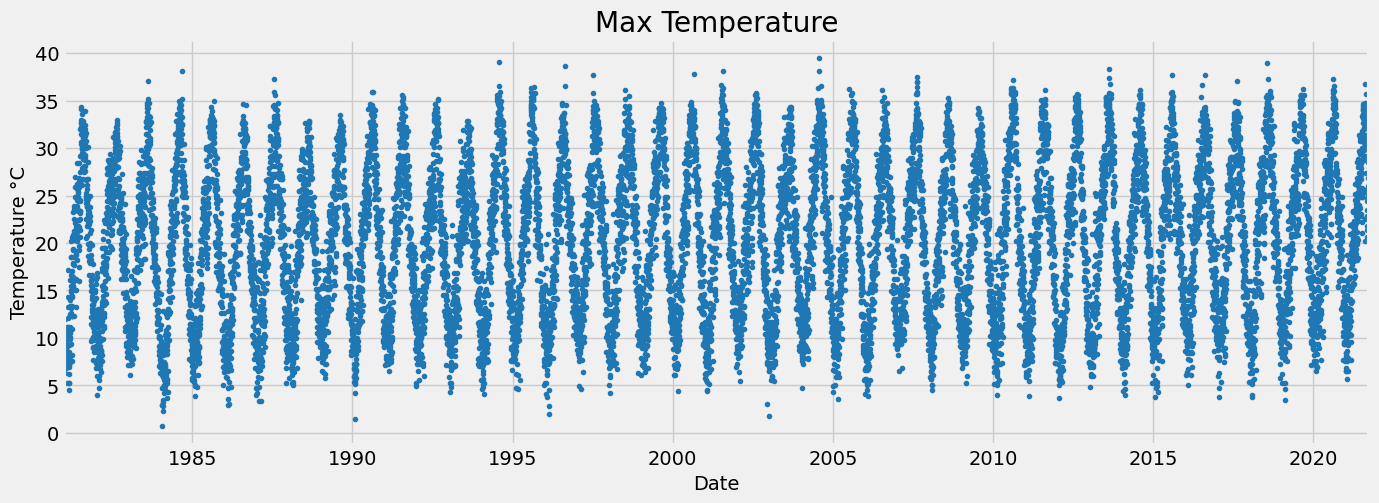

In [8]:
df.plot(x='Date',y='Max temp',style='.', color=color_pal[0], ylabel='Temperature °C')
plt.title('Max Temperature')
plt.legend('', frameon=False)

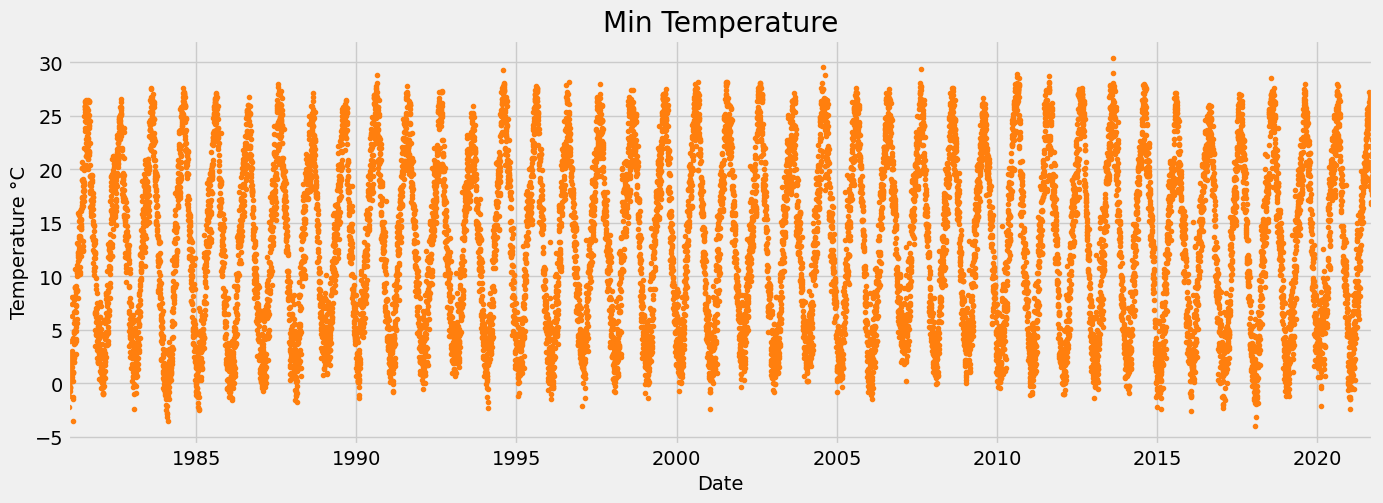

In [9]:
df.plot(x='Date',y='Min temp',style='.', color=color_pal[1], ylabel='Temperature °C')
plt.title('Min Temperature')
plt.legend('', frameon=False)

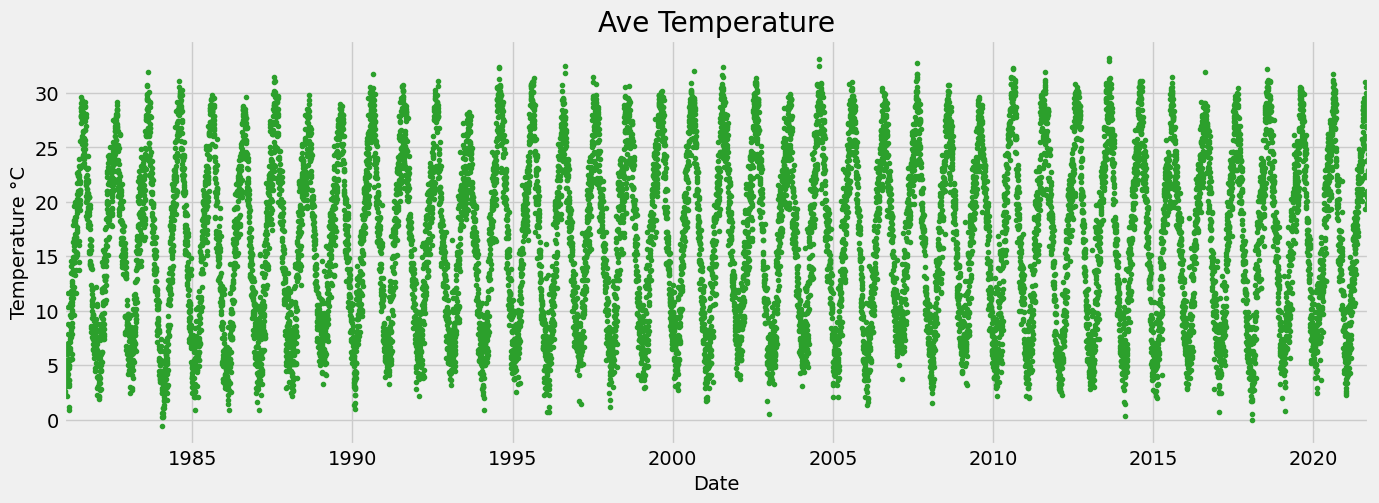

In [10]:
df.plot(x='Date',y='Ave temp',style='.', color=color_pal[2], ylabel='Temperature °C')
plt.title('Ave Temperature')
plt.legend('', frameon=False)

# Visualizing temperature year by year

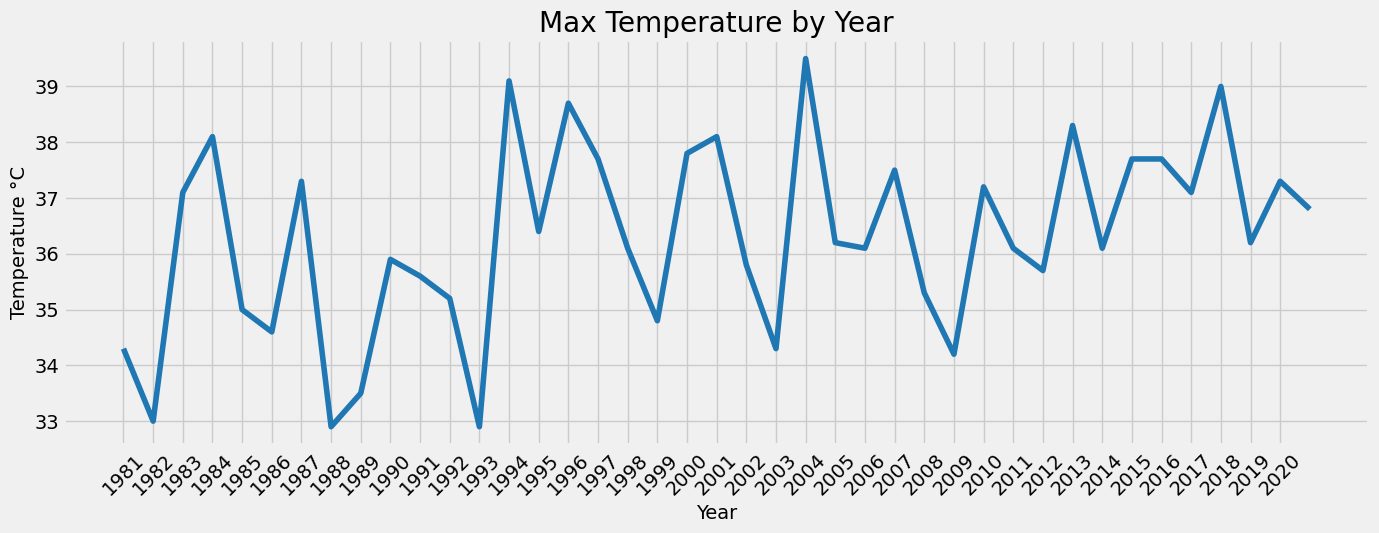

In [11]:
max_T_yr = df.groupby('Year')[['Max temp']].max()
max_T_yr.plot(style='-', color=color_pal[0], ylabel='Temperature °C', rot=45)
plt.xticks(np.arange(1981,2021,1))
plt.title('Max Temperature by Year')
plt.legend('', frameon=False)

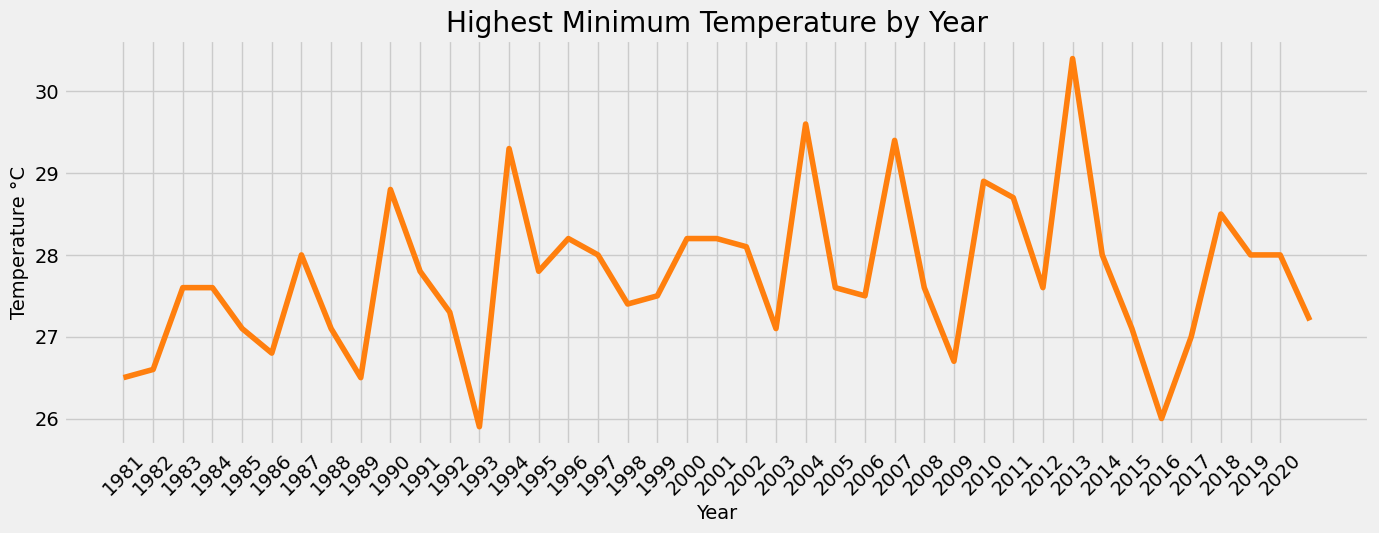

In [12]:
ave_T_yr = df.groupby('Year')[['Min temp']].max()
ave_T_yr.plot(style='-', color=color_pal[1], ylabel='Temperature °C', rot=45)
plt.xticks(np.arange(1981,2021,1))
plt.title('Highest Minimum Temperature by Year')
plt.legend('', frameon=False)

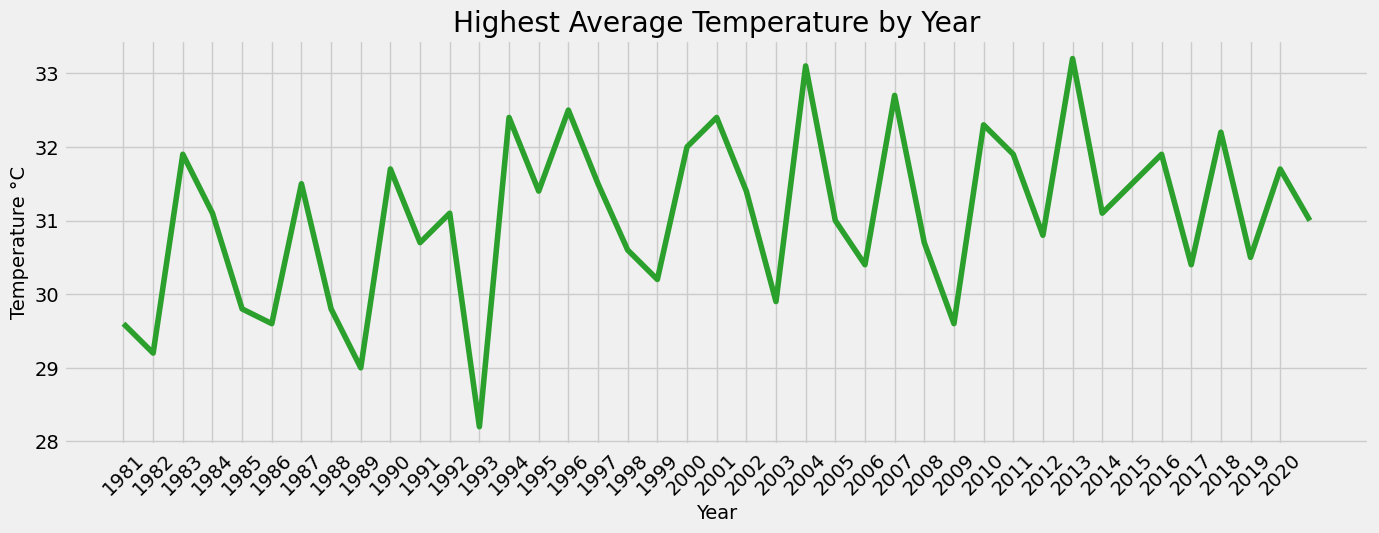

In [13]:
ave_T_yr = df.groupby('Year')[['Ave temp']].max()
ave_T_yr.plot(style='-', color=color_pal[2], ylabel='Temperature °C', rot=45)
plt.xticks(np.arange(1981,2021,1))
plt.title('Highest Average Temperature by Year')
plt.legend('', frameon=False)

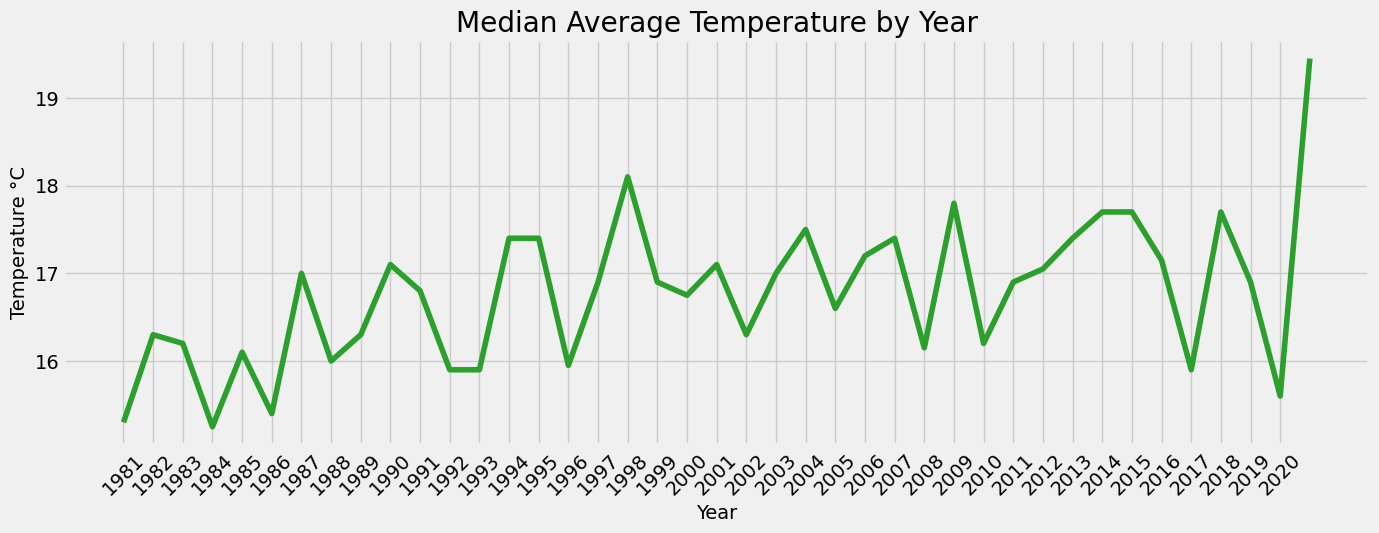

In [14]:
#median averagae temp by year
median_ave_T_yr = df.groupby('Year')[['Ave temp']].median()
median_ave_T_yr.plot(style='-', color=color_pal[2], ylabel='Temperature °C', rot=45)
plt.xticks(np.arange(1981,2021,1))
plt.title('Median Average Temperature by Year')
plt.legend('', frameon=False)

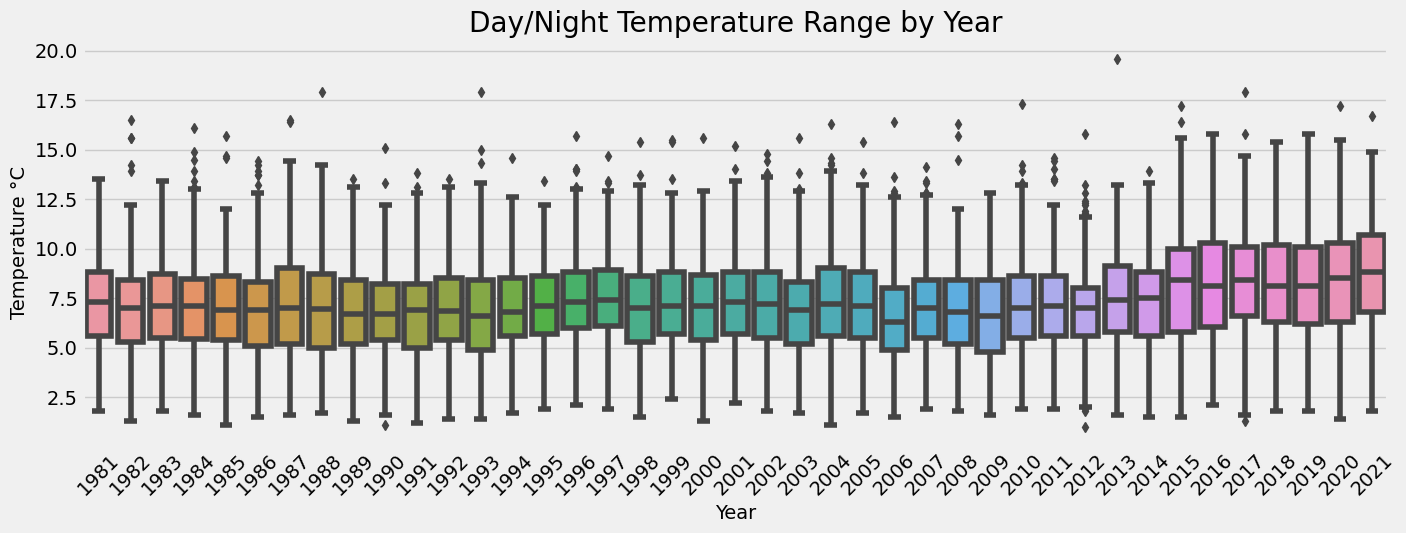

In [15]:
sns.boxplot(data=df,x='Year', y='Temp variation')
plt.title('Daily Max-Min Temperature Range by Year')
plt.ylabel('Temperature °C')
plt.xticks(rotation=45)
plt.show()

# Max Temperatures Over the Years

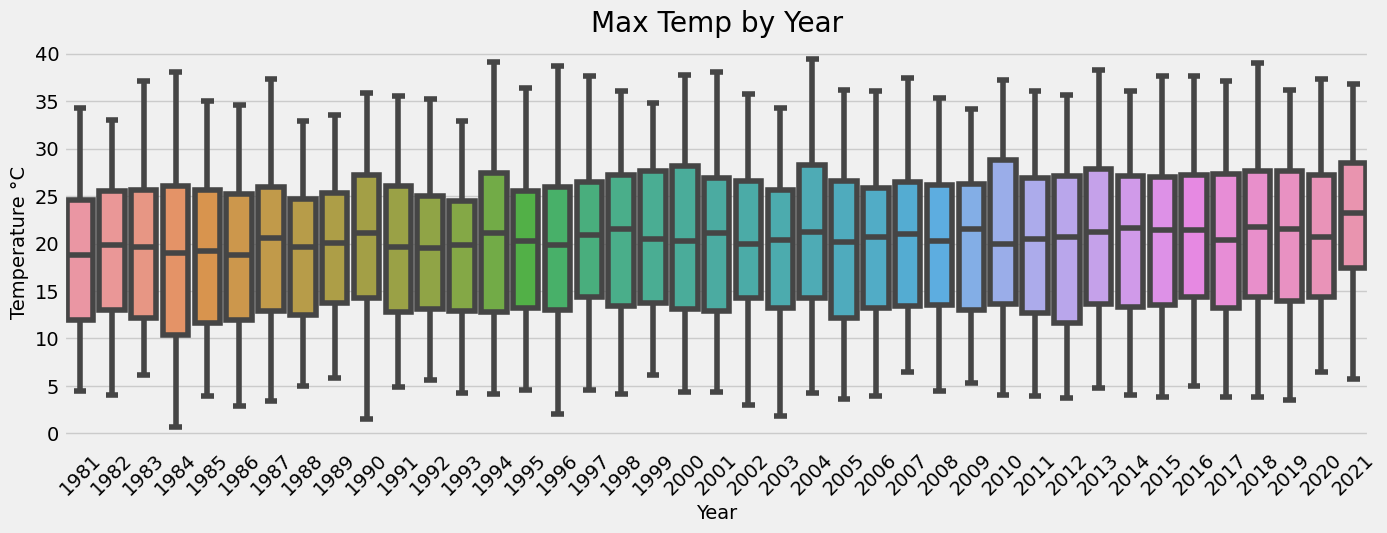

In [16]:
sns.boxplot(data=df,x='Year', y='Max temp')
plt.title('Max Temp by Year')
plt.ylabel('Temperature °C')
plt.xticks(rotation=45)
plt.show()

Text(0.5, 0, 'Temperature')

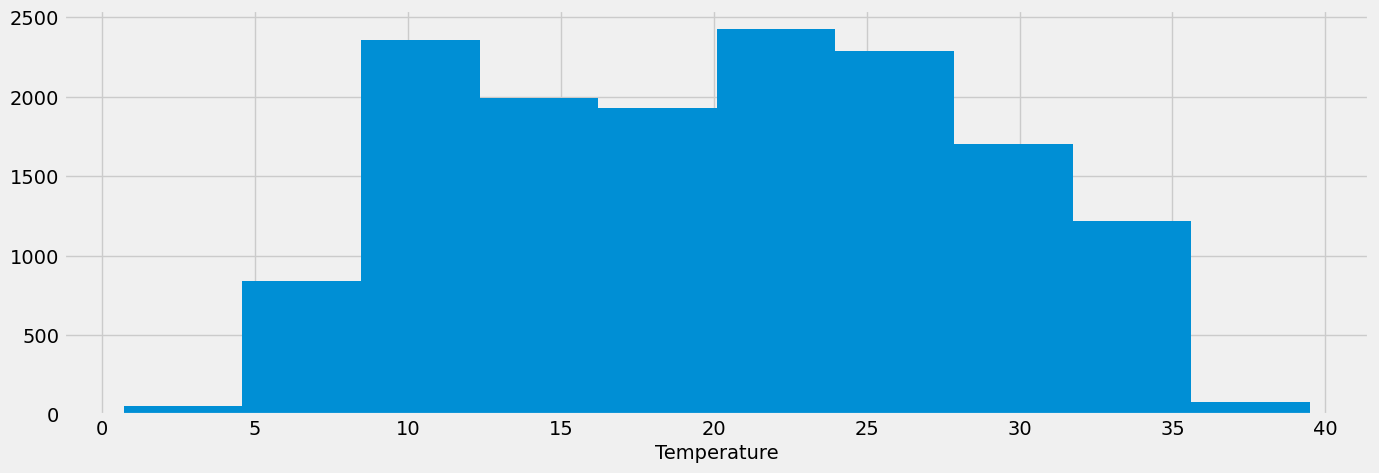

In [17]:
df['Max temp'].hist()
plt.xlabel('Temperature')

# Max Temperature Train/Test Split

In [18]:
train = df.loc[df.index < '2018-12-31']
test = df.loc[df.index > '2019-01-01']
train

,Date,Ave temp,Max temp,Min temp,Week,Month,Quarter,Year,Temp variation
Date Index,,,,,,,,,
1981-01-01,1981-01-01,5.0,8.9,1.3,1,1,1,1981,7.6
1981-01-02,1981-01-02,4.6,7.5,1.9,1,1,1,1981,5.6
1981-01-03,1981-01-03,5.1,9.0,2.2,1,1,1,1981,6.8
1981-01-04,1981-01-04,4.4,9.6,-0.6,1,1,1,1981,10.2
1981-01-05,1981-01-05,4.1,8.4,0.0,2,1,1,1981,8.4
...,...,...,...,...,...,...,...,...,...
2018-12-26,2018-12-26,7.3,11.7,1.2,52,12,4,2018,10.5
2018-12-27,2018-12-27,9.0,13.2,4.9,52,12,4,2018,8.3
2018-12-28,2018-12-28,4.8,8.4,1.8,52,12,4,2018,6.6


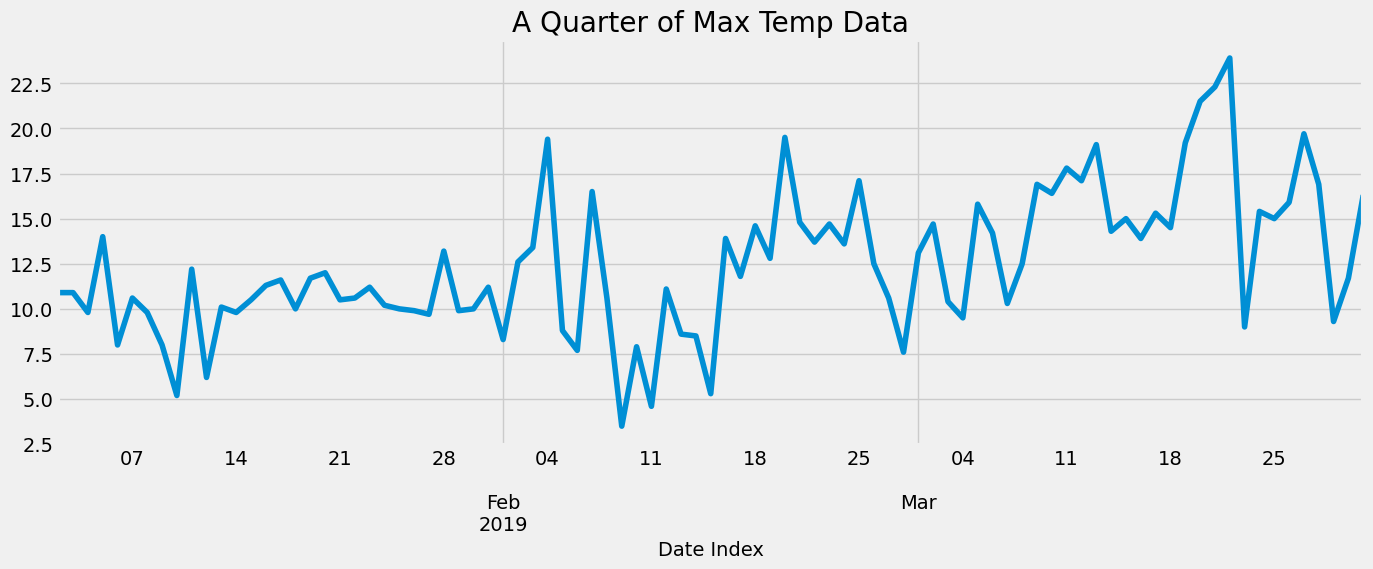

In [19]:
#plotting a quarter of max temp data
df.loc[(df.index > '2019-01-01') & (df.index < '2019-04-01')][['Max temp']].plot(title='A Quarter of Max Temp Data')
plt.legend('', frameon=False)
plt.show()

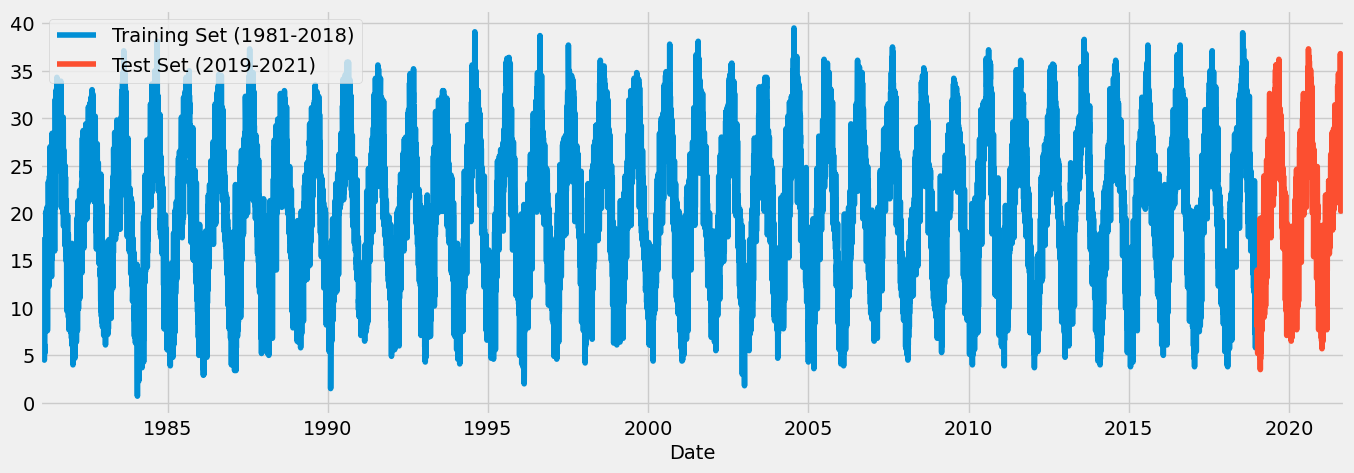

In [20]:
fig, ax = plt.subplots()
train.plot(ax=ax, x='Date', y='Max temp')
test.plot(ax=ax, x='Date', y='Max temp')
ax.legend(['Training Set (1981-2018)','Test Set (2019-2021)'])
plt.show()

Text(0.5, 1.0, 'Max Temperatures by Month')

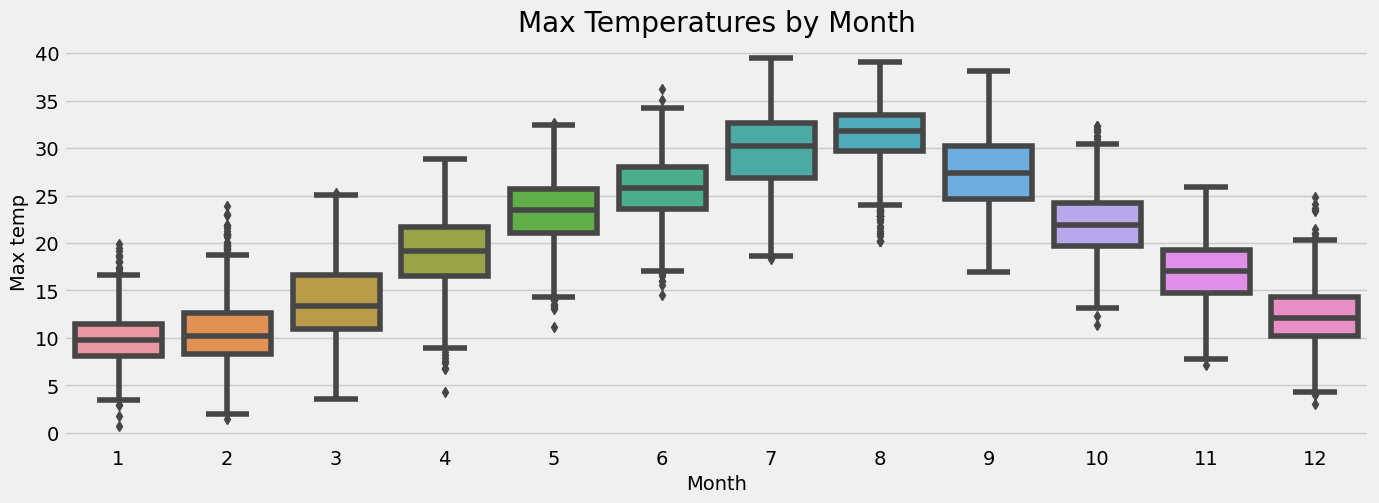

In [21]:
sns.boxplot(data=df, x='Month', y='Max temp')
plt.title('Max Temperatures by Month')

# Regression model for max temp (without cross-validation and lag features)

In [22]:
FEATURES = ['Year','Quarter','Month', 'Week']
TARGET = 'Max temp'

X_train = train[FEATURES]
Y_train = train[TARGET]

X_test = test[FEATURES]
Y_test = test[TARGET]

reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                      learning_rate=0.01)
reg.fit(X_train, Y_train, 
       eval_set=[(X_train, Y_train), (X_test, Y_test)],
       verbose=50)

[0]	validation_0-rmse:7.91015	validation_1-rmse:7.87086
[50]	validation_0-rmse:5.41133	validation_1-rmse:5.49916
[100]	validation_0-rmse:4.10934	validation_1-rmse:4.32983
[150]	validation_0-rmse:3.49269	validation_1-rmse:3.83218
[200]	validation_0-rmse:3.22177	validation_1-rmse:3.67797
[250]	validation_0-rmse:3.10163	validation_1-rmse:3.65002
[294]	validation_0-rmse:3.04829	validation_1-rmse:3.67102


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Max Temp Feature Importances

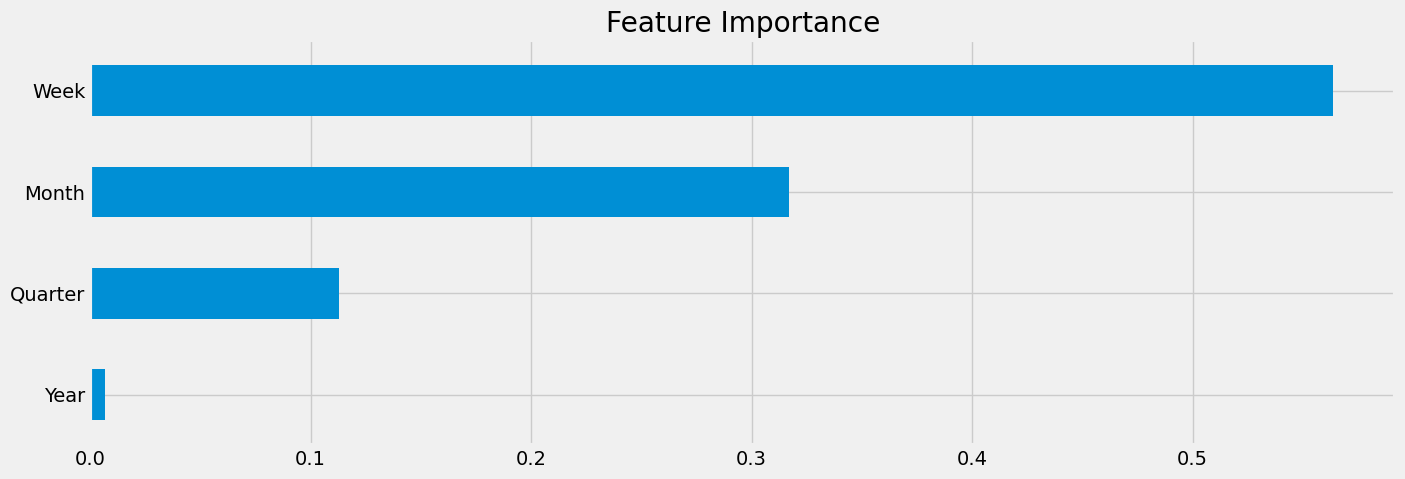

In [23]:
fi = pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.legend('', frameon=False)
plt.show()

# Forecast on max temp test data - validation set

In [24]:
test['Prediction_MAX'] = reg.predict(X_test)
df = df.merge(test['Prediction_MAX'], how='left', left_index=True, right_index=True)
df

C:\Users\mflor\AppData\Local\Temp\ipykernel_10856\1022910206.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction_MAX'] = reg.predict(X_test)


,Date,Ave temp,Max temp,Min temp,Week,Month,Quarter,Year,Temp variation,Prediction_MAX
Date Index,,,,,,,,,,
1981-01-01,1981-01-01,5.0,8.9,1.3,1,1,1,1981,7.6,NaN
1981-01-02,1981-01-02,4.6,7.5,1.9,1,1,1,1981,5.6,NaN
1981-01-03,1981-01-03,5.1,9.0,2.2,1,1,1,1981,6.8,NaN
1981-01-04,1981-01-04,4.4,9.6,-0.6,1,1,1,1981,10.2,NaN
1981-01-05,1981-01-05,4.1,8.4,0.0,2,1,1,1981,8.4,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-09-23,2021-09-23,26.6,31.7,22.9,38,9,3,2021,8.8,26.104244
2021-09-24,2021-09-24,25.4,30.6,21.2,38,9,3,2021,9.4,26.104244
2021-09-25,2021-09-25,22.1,24.5,20.3,38,9,3,2021,4.2,26.104244


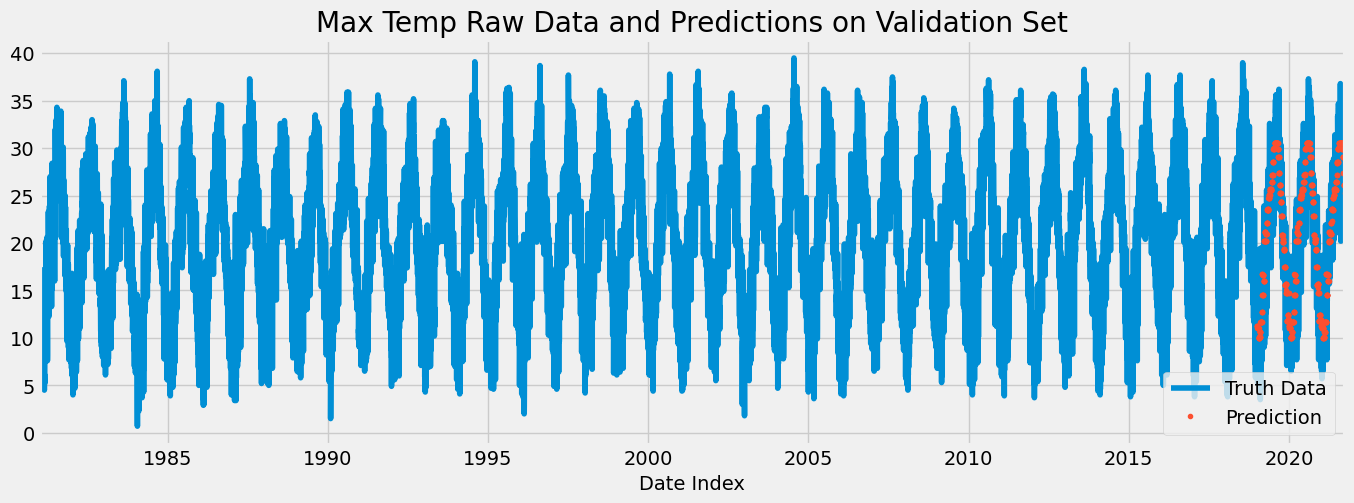

In [25]:
ax = df[['Max temp']].plot()
df['Prediction_MAX'].plot(ax=ax, style='.')
plt.legend(['Truth Data','Prediction'])
ax.set_title('Max Temp Raw Data and Predictions on Validation Set')
plt.show()

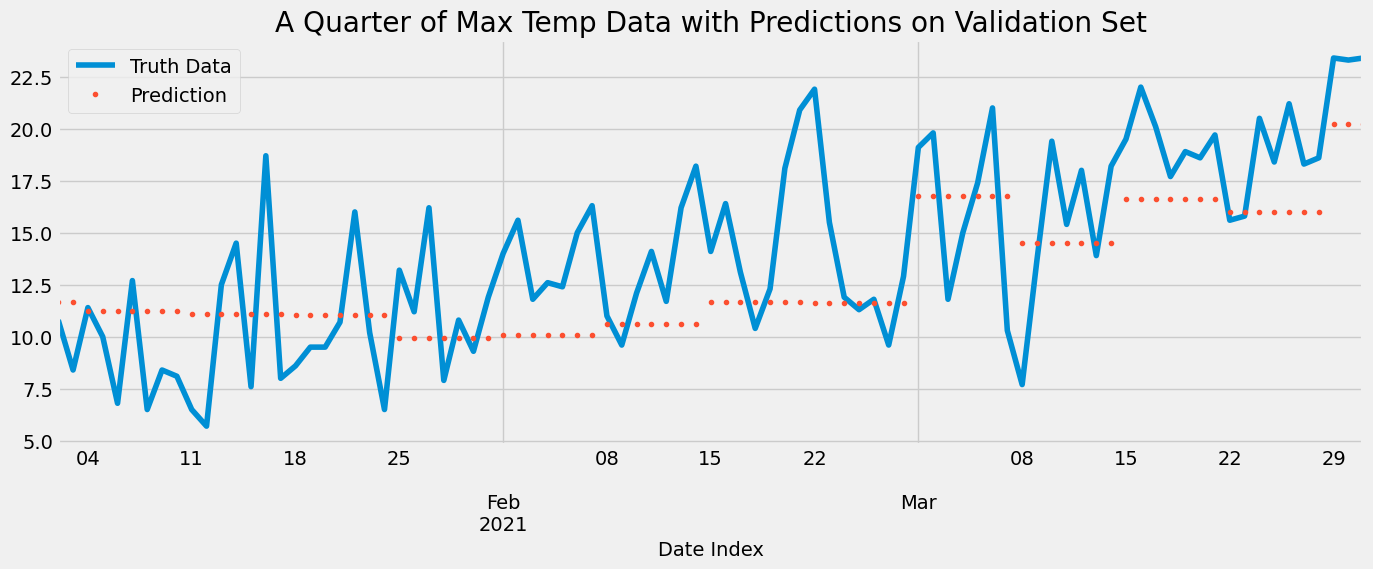

In [26]:
#plotting max temp data over a quarter w/ predictions
ax = df.loc[(df.index > '2021-01-01') & (df.index < '2021-04-01')]['Max temp']\
        .plot(title='A Quarter of Max Temp Data with Predictions on Validation Set', style='-')
df.loc[(df.index > '2021-01-01') & (df.index < '2021-04-01')]['Prediction_MAX'].plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Regression model training with cross-validation and time lag features - Max Temperature data

## Lag features

In [27]:
def add_lag(df, target):
    #1, 2, 3, 5, 10, 15 year lag
    target_map = df[target].to_dict()
    df[f'lag_1_{target}'] = (df.index - pd.Timedelta(364, 'd')).map(target_map)
    df[f'lag_2_{target}'] = (df.index - pd.Timedelta(728, 'd')).map(target_map)
    df[f'lag_3_{target}'] = (df.index - pd.Timedelta(1092,'d')).map(target_map)
    df[f'lag_4_{target}'] = (df.index - pd.Timedelta(1820,'d')).map(target_map)
    df[f'lag_5_{target}'] = (df.index - pd.Timedelta(3640,'d')).map(target_map)
    df[f'lag_6_{target}'] = (df.index - pd.Timedelta(5460,'d')).map(target_map)
    
    return df

In [28]:
df = add_lag(df, 'Max temp')
df.tail()

,Date,Ave temp,Max temp,Min temp,Week,Month,Quarter,Year,Temp variation,Prediction_MAX,lag_1_Max temp,lag_2_Max temp,lag_3_Max temp,lag_4_Max temp,lag_5_Max temp,lag_6_Max temp
Date Index,,,,,,,,,,,,,,,,
2021-09-23,2021-09-23,26.6,31.7,22.9,38,9,3,2021,8.8,26.104244,22.2,27.4,17.5,27.9,25.5,27.0
2021-09-24,2021-09-24,25.4,30.6,21.2,38,9,3,2021,9.4,26.104244,20.8,28.1,26.0,24.7,25.6,22.9
2021-09-25,2021-09-25,22.1,24.5,20.3,38,9,3,2021,4.2,26.104244,20.0,29.6,21.3,21.8,23.2,22.2
2021-09-26,2021-09-26,19.9,21.3,18.2,38,9,3,2021,3.1,26.104244,23.5,27.7,27.0,27.6,22.8,21.4
2021-09-27,2021-09-27,20.1,24.8,17.0,39,9,3,2021,7.8,25.233589,27.4,29.7,32.3,26.5,24.3,25.7


In [30]:
#train 5 folds and score the model

from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size = 365*1, gap=1)
df = df.sort_index()

preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    

    FEATURES = ['Week','Month','Quarter','Year','lag_1_Max temp','lag_2_Max temp','lag_3_Max temp',
               'lag_4_Max temp','lag_5_Max temp','lag_6_Max temp']
    TARGET = 'Max temp'
    
    X_train = train[FEATURES]
    Y_train = train[TARGET]
    X_test = test[FEATURES]
    Y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                          n_estimators=1000, 
                          early_stopping_rounds=50,
                          objective='reg:squarederror',
                          max_depth=3,
                          learning_rate=0.01)
    reg.fit(X_train, Y_train,
           eval_set=[(X_train, Y_train),(X_test, Y_test)],
           verbose=100)
    
    Y_pred = reg.predict(X_test)
    preds.append(Y_pred)
    #score the model - mean squared error gives penalties to the model
    score = np.sqrt(mean_squared_error(Y_test, Y_pred))
    scores.append(score)


[0]	validation_0-rmse:20.97725	validation_1-rmse:21.52931
[100]	validation_0-rmse:8.39843	validation_1-rmse:8.61043
[200]	validation_0-rmse:4.37578	validation_1-rmse:4.48344
[300]	validation_0-rmse:3.41247	validation_1-rmse:3.52138
[400]	validation_0-rmse:3.21535	validation_1-rmse:3.37377
[500]	validation_0-rmse:3.16304	validation_1-rmse:3.36273
[558]	validation_0-rmse:3.14834	validation_1-rmse:3.36345
[0]	validation_0-rmse:20.99296	validation_1-rmse:21.85960
[100]	validation_0-rmse:8.40026	validation_1-rmse:9.09660
[200]	validation_0-rmse:4.37999	validation_1-rmse:5.04932
[300]	validation_0-rmse:3.42210	validation_1-rmse:4.03973
[400]	validation_0-rmse:3.22104	validation_1-rmse:3.80683
[500]	validation_0-rmse:3.16583	validation_1-rmse:3.74423
[600]	validation_0-rmse:3.14312	validation_1-rmse:3.71686
[700]	validation_0-rmse:3.12522	validation_1-rmse:3.70004
[800]	validation_0-rmse:3.10990	validation_1-rmse:3.69456
[900]	validation_0-rmse:3.09673	validation_1-rmse:3.69305
[929]	validati

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.legend('', frameon=False)
plt.show()

In [31]:
print(f'Score across folds: {np.mean(scores)}')
print(f'Fold scores: {scores}')

Score across folds: 3.5341425750015034
Fold scores: [3.3624045882841633, 3.6927911934939237, 3.420315779621174, 3.695759507303712, 3.499441806304543]


In [32]:
test['New Prediction_MAX'] = reg.predict(X_test)
df = df.merge(test['New Prediction_MAX'], how='left', left_index=True, right_index=True)
df

C:\Users\mflor\AppData\Local\Temp\ipykernel_10856\3192362357.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['New Prediction_MAX'] = reg.predict(X_test)


,Date,Ave temp,Max temp,Min temp,Week,Month,Quarter,Year,Temp variation,Prediction_MAX,lag_1_Max temp,lag_2_Max temp,lag_3_Max temp,lag_4_Max temp,lag_5_Max temp,lag_6_Max temp,New Prediction_MAX
Date Index,,,,,,,,,,,,,,,,,
1981-01-01,1981-01-01,5.0,8.9,1.3,1,1,1,1981,7.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-02,1981-01-02,4.6,7.5,1.9,1,1,1,1981,5.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-03,1981-01-03,5.1,9.0,2.2,1,1,1,1981,6.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-04,1981-01-04,4.4,9.6,-0.6,1,1,1,1981,10.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-05,1981-01-05,4.1,8.4,0.0,2,1,1,1981,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-23,2021-09-23,26.6,31.7,22.9,38,9,3,2021,8.8,26.104244,22.2,27.4,17.5,27.9,25.5,27.0,24.860868
2021-09-24,2021-09-24,25.4,30.6,21.2,38,9,3,2021,9.4,26.104244,20.8,28.1,26.0,24.7,25.6,22.9,25.822361
2021-09-25,2021-09-25,22.1,24.5,20.3,38,9,3,2021,4.2,26.104244,20.0,29.6,21.3,21.8,23.2,22.2,24.270220


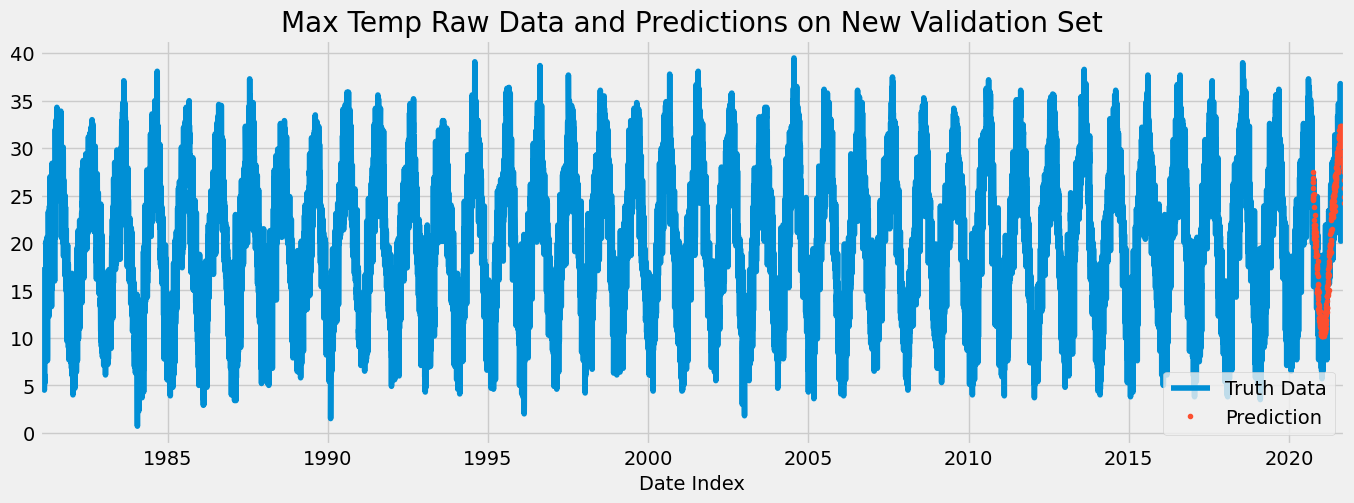

In [33]:
ax = df[['Max temp']].plot()
df['New Prediction_MAX'].plot(ax=ax, style='.')
plt.legend(['Truth Data','Prediction'])
ax.set_title('Max Temp Raw Data and Predictions on New Validation Set')
plt.show()

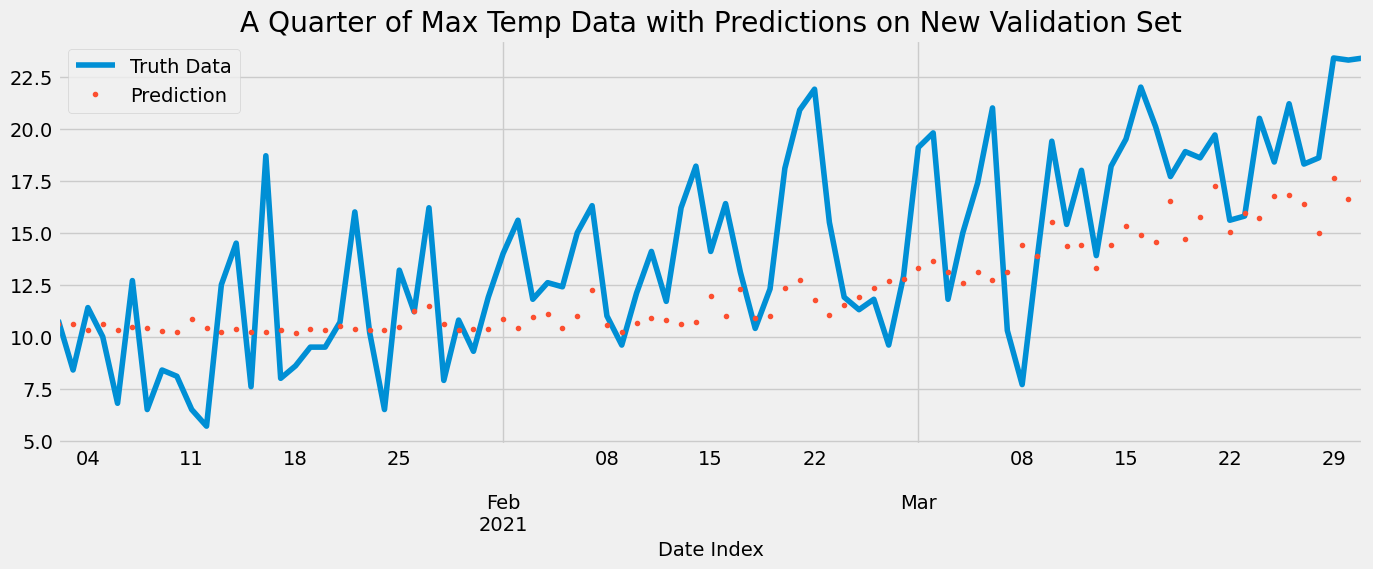

In [34]:
#plotting max temp data over a quarter w/ predictions
ax = df.loc[(df.index > '2021-01-01') & (df.index < '2021-04-01')]['Max temp']\
        .plot(title='A Quarter of Max Temp Data with Predictions on New Validation Set', style='-')
df.loc[(df.index > '2021-01-01') & (df.index < '2021-04-01')]['New Prediction_MAX'].plot(ax=ax,style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Forecasting max temperatures with 5 folds and lag features - predict 3 years into the future

In [35]:
#the model seems good so for the forecasting we need to retrain on all of the data
FEATURES = ['Week','Month','Quarter','Year','lag_1_Max temp','lag_2_Max temp','lag_3_Max temp']
TARGET = 'Max temp'

X_all = df[FEATURES]
Y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                          n_estimators=1000, 
                          early_stopping_rounds=50,
                          objective='reg:squarederror',
                          max_depth=3,
                          learning_rate=0.01)
reg.fit(X_all, Y_all,
       eval_set=[(X_all, Y_all)],
       verbose=100)

[0]	validation_0-rmse:21.07359
[100]	validation_0-rmse:8.45582
[200]	validation_0-rmse:4.43471
[300]	validation_0-rmse:3.47495
[400]	validation_0-rmse:3.28173
[500]	validation_0-rmse:3.23099
[600]	validation_0-rmse:3.20716
[700]	validation_0-rmse:3.19036
[800]	validation_0-rmse:3.17465
[900]	validation_0-rmse:3.16074
[999]	validation_0-rmse:3.14882


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [36]:
max_forecast = pd.date_range(start='2021-09-28', end='2024-09-28')
max_forecast_df = pd.DataFrame(index=max_forecast)
max_forecast_df['isFuture'] = True
df['isFuture'] = False

df_and_forecast = pd.concat([df,max_forecast_df])
df_and_forecast = create_features(df_and_forecast)
df_and_forecast = add_lag(df_and_forecast, 'Max temp')
df_and_forecast

,Date,Ave temp,Max temp,Min temp,Week,Month,Quarter,Year,Temp variation,Prediction_MAX,lag_1_Max temp,lag_2_Max temp,lag_3_Max temp,lag_4_Max temp,lag_5_Max temp,lag_6_Max temp,New Prediction_MAX,isFuture
1981-01-01,1981-01-01,5.0,8.9,1.3,1,1,1,1981,7.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1981-01-02,1981-01-02,4.6,7.5,1.9,1,1,1,1981,5.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1981-01-03,1981-01-03,5.1,9.0,2.2,1,1,1,1981,6.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1981-01-04,1981-01-04,4.4,9.6,-0.6,1,1,1,1981,10.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1981-01-05,1981-01-05,4.1,8.4,0.0,2,1,1,1981,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-24,NaT,NaN,NaN,NaN,39,9,3,2024,NaN,NaN,NaN,NaN,NaN,30.1,24.0,24.9,NaN,True
2024-09-25,NaT,NaN,NaN,NaN,39,9,3,2024,NaN,NaN,NaN,NaN,NaN,29.6,24.4,20.8,NaN,True
2024-09-26,NaT,NaN,NaN,NaN,39,9,3,2024,NaN,NaN,NaN,NaN,NaN,28.3,24.0,21.8,NaN,True
2024-09-27,NaT,NaN,NaN,NaN,39,9,3,2024,NaN,NaN,NaN,NaN,NaN,29.4,26.3,22.4,NaN,True


In [37]:
max_future_features = df_and_forecast.query('isFuture').copy()
max_future_features['MAX Pred']=reg.predict(max_future_features[FEATURES])
max_future_features

,Date,Ave temp,Max temp,Min temp,Week,Month,Quarter,Year,Temp variation,Prediction_MAX,lag_1_Max temp,lag_2_Max temp,lag_3_Max temp,lag_4_Max temp,lag_5_Max temp,lag_6_Max temp,New Prediction_MAX,isFuture,MAX Pred
2021-09-28,NaT,NaN,NaN,NaN,39,9,3,2021,NaN,NaN,23.1,30.1,26.9,32.0,25.2,25.1,NaN,True,26.090202
2021-09-29,NaT,NaN,NaN,NaN,39,9,3,2021,NaN,NaN,25.4,29.6,23.3,26.4,23.4,23.8,NaN,True,26.015556
2021-09-30,NaT,NaN,NaN,NaN,39,9,3,2021,NaN,NaN,24.3,28.3,21.4,31.3,23.7,24.4,NaN,True,25.582672
2021-10-01,NaT,NaN,NaN,NaN,39,10,4,2021,NaN,NaN,26.7,29.4,20.1,24.9,25.4,23.5,NaN,True,26.170767
2021-10-02,NaT,NaN,NaN,NaN,39,10,4,2021,NaN,NaN,26.3,30.3,29.3,25.3,26.9,21.4,NaN,True,26.504993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-24,NaT,NaN,NaN,NaN,39,9,3,2024,NaN,NaN,NaN,NaN,NaN,30.1,24.0,24.9,NaN,True,24.615614
2024-09-25,NaT,NaN,NaN,NaN,39,9,3,2024,NaN,NaN,NaN,NaN,NaN,29.6,24.4,20.8,NaN,True,24.615614
2024-09-26,NaT,NaN,NaN,NaN,39,9,3,2024,NaN,NaN,NaN,NaN,NaN,28.3,24.0,21.8,NaN,True,24.615614
2024-09-27,NaT,NaN,NaN,NaN,39,9,3,2024,NaN,NaN,NaN,NaN,NaN,29.4,26.3,22.4,NaN,True,24.615614


In [38]:
max_future_features

,Date,Ave temp,Max temp,Min temp,Week,Month,Quarter,Year,Temp variation,Prediction_MAX,lag_1_Max temp,lag_2_Max temp,lag_3_Max temp,lag_4_Max temp,lag_5_Max temp,lag_6_Max temp,New Prediction_MAX,isFuture,MAX Pred
2021-09-28,NaT,NaN,NaN,NaN,39,9,3,2021,NaN,NaN,23.1,30.1,26.9,32.0,25.2,25.1,NaN,True,26.090202
2021-09-29,NaT,NaN,NaN,NaN,39,9,3,2021,NaN,NaN,25.4,29.6,23.3,26.4,23.4,23.8,NaN,True,26.015556
2021-09-30,NaT,NaN,NaN,NaN,39,9,3,2021,NaN,NaN,24.3,28.3,21.4,31.3,23.7,24.4,NaN,True,25.582672
2021-10-01,NaT,NaN,NaN,NaN,39,10,4,2021,NaN,NaN,26.7,29.4,20.1,24.9,25.4,23.5,NaN,True,26.170767
2021-10-02,NaT,NaN,NaN,NaN,39,10,4,2021,NaN,NaN,26.3,30.3,29.3,25.3,26.9,21.4,NaN,True,26.504993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-24,NaT,NaN,NaN,NaN,39,9,3,2024,NaN,NaN,NaN,NaN,NaN,30.1,24.0,24.9,NaN,True,24.615614
2024-09-25,NaT,NaN,NaN,NaN,39,9,3,2024,NaN,NaN,NaN,NaN,NaN,29.6,24.4,20.8,NaN,True,24.615614
2024-09-26,NaT,NaN,NaN,NaN,39,9,3,2024,NaN,NaN,NaN,NaN,NaN,28.3,24.0,21.8,NaN,True,24.615614
2024-09-27,NaT,NaN,NaN,NaN,39,9,3,2024,NaN,NaN,NaN,NaN,NaN,29.4,26.3,22.4,NaN,True,24.615614


<Axes: title={'center': 'Max Temp Predictions'}>

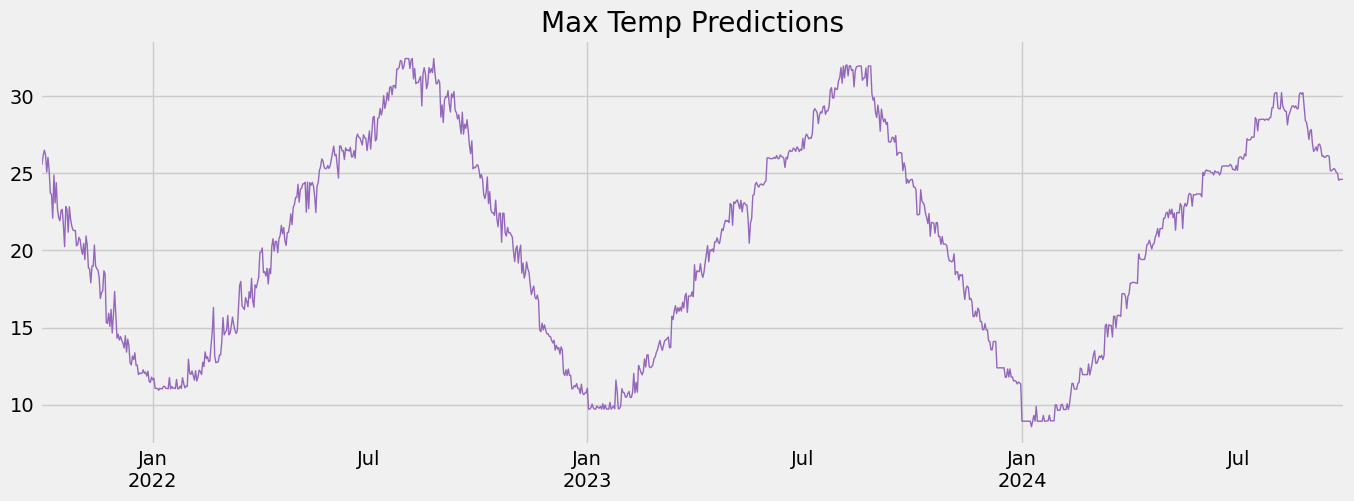

In [39]:
max_future_features['MAX Pred'].plot(x='Date',
                                    color=color_pal[4],
                                    ms=1,
                                    lw=1,
                                    title='Max Temp Predictions')

In [39]:
#saving the max temp model
#reg.save_model('Tokyo_max_T_model.json')